![Kickstarter](misc/kickstarter_logo.png)

# Analysis of Data from Kickstarter Projects
### Data taken from Kaggle (https://www.kaggle.com/kemical/kickstarter-projects)

# Zielfragestellung: Gibt es Trends in den Erfolgen von Projekten? Sind manche Kategorien erfolgreicher als andere, und wenn ja wieso?

- Gibt es Trends / Merkmale von erfolgreichen Projekten? Sollte man bestimmte Projektarten besonders fördern bzw. bewerben?
    - bereits gefunden: Trends in unterschiedlichen Produktkategorien --- Textchart
        - evtl. nochmal weiter unterteilen und schauen, ob es eine besonders erfolgreiche Subkategorie gibt
    - bereits gefunden: Trends in unterschiedlichen Preiskategorien (günstiger -> i.d.R. erfolgreicher) --- Tabelle
        - lässt sich in Kombination mit zwei exemplarischen Produktkategorien und deren "besten Phasen" verdeutlichen --- Plot
        - spiegeln sich die Preiskategorien auch in den Produktkategorien wieder? Sind die erfolgreichen Produktkategorien günstiger als die teuren? --- Textplot
    - bereits gefunden: Gibt es Trends bzgl. der Projektlaufzeiten? -> Zeitreihenanalyse --- Plot
    - lassen sich die Projekte clustern? Findet man ein Cluster der besonders erfolgreichen wieder?

In [1]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt

filename = 'data/ks-projects-201801.csv'
df = pd.read_csv(filename)

In [2]:
df.head()

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real
0,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09,1000.0,2015-08-11 12:12:28,0.0,failed,0,GB,0.0,0.0,1533.95
1,1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017-11-01,30000.0,2017-09-02 04:43:57,2421.0,failed,15,US,100.0,2421.0,30000.00
2,1000004038,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26,45000.0,2013-01-12 00:20:50,220.0,failed,3,US,220.0,220.0,45000.00
3,1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16,5000.0,2012-03-17 03:24:11,1.0,failed,1,US,1.0,1.0,5000.00
4,1000011046,Community Film Project: The Art of Neighborhoo...,Film & Video,Film & Video,USD,2015-08-29,19500.0,2015-07-04 08:35:03,1283.0,canceled,14,US,1283.0,1283.0,19500.00


The first look at the data shows that there are some interesting questions one can ask about the Projects of Kickstarter. <br>
Some possible questions are:
> What (main) category is typically the most successful? <br>
What are people willing to pledge for different categories? <br>
Is there a threshold for the money, at which most projects fail? <br>
Is it possible to predict the success ratio based on the other values? <br>
What countries do have the most successful projects? What country do the most backers come from? <br>
What impact does the deadline have on the backers and on the state? Do people tend to pledge more if the deadline is near or far? <br>

I'm going to take a closer look at the following questions:
> What (main) category is typically the most successful? <br>
What are people willing to pledge (avg, median, mode) for different categories? <br>
What impact does the deadline have on the backers and on the state? Do people tend to pledge more if the deadline is near or far? <br>

In [3]:
# remove columns which aren't used during analysis
df.drop(['usd pledged', 'usd_pledged_real', 'usd_goal_real'], axis=1, inplace=True)

# convert launched and deadline columns
from datetime import datetime
df['launched'] = df['launched'].apply(lambda x: datetime.strptime(x[:10], "%Y-%m-%d"))
df['deadline'] = df['deadline'].apply(lambda x: datetime.strptime(x, "%Y-%m-%d"))
df['year_deadline'] = df['deadline'].apply(lambda x: x.year)
df['project_runtime'] = df['deadline'] - df['launched']
df['project_runtime'] = df['project_runtime'].apply(lambda x: int(x.days)) # project runtime in days

# calculate difference between money goal and real pledge
df['diff_goal_pledged'] = df['pledged'] - df['goal']

In [4]:
df.head()

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,year_deadline,project_runtime,diff_goal_pledged
0,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09,1000.0,2015-08-11,0.0,failed,0,GB,2015,59,-1000.0
1,1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017-11-01,30000.0,2017-09-02,2421.0,failed,15,US,2017,60,-27579.0
2,1000004038,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26,45000.0,2013-01-12,220.0,failed,3,US,2013,45,-44780.0
3,1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16,5000.0,2012-03-17,1.0,failed,1,US,2012,30,-4999.0
4,1000011046,Community Film Project: The Art of Neighborhoo...,Film & Video,Film & Video,USD,2015-08-29,19500.0,2015-07-04,1283.0,canceled,14,US,2015,56,-18217.0


### What (main) category is typically the most successful? Are there categories which are more likely to succeed / fail?

In [5]:
overall_states = df['state'].value_counts(normalize=True)

In [6]:
from collections import defaultdict
group_cat_to_state = df.groupby(['main_category'])['state'].value_counts(normalize=True)
cat_state_dict = defaultdict(dict)
for idx, value in enumerate(group_cat_to_state):
    cat, state = group_cat_to_state.index[idx]
    cat_state_dict[cat][state] = value # example: Art & Failed -> 14039

In [7]:
X = []
Y = []
Annotations = []
for cat, state_value_dict in cat_state_dict.items():
    for state, value in state_value_dict.items():
        X.append(state)
        Y.append(value)
        Annotations.append(cat)
        #print(cat, state, value)

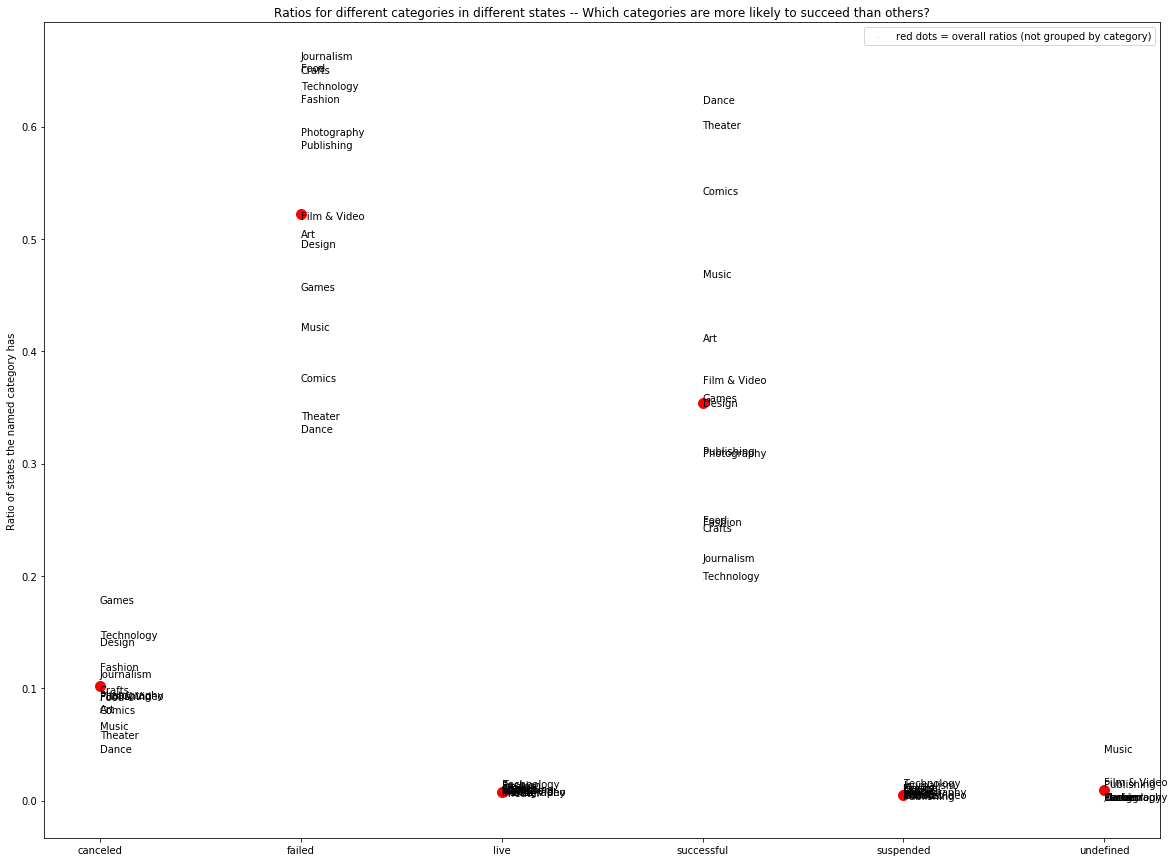

In [8]:
fig, ax = plt.subplots()
fig.set_size_inches(20, 15)
ax.scatter(x=X, y=Y, s=0.01) # data point is too small to see (-> show only text)
for i, txt in enumerate(Annotations):
    ax.annotate(txt, (X[i], Y[i])) # places the text annotation at the data point
ax.scatter(x=list(overall_states.index), y=list(overall_states.values), s=100, c='r') # overall states ratio
plt.ylabel("Ratio of states the named category has")
plt.title("Ratios for different categories in different states -- Which categories are more likely to succeed than others?")
plt.legend(["red dots = overall ratios (not grouped by category)"])
plt.show()

In [9]:
successful_cats = ['Dance', 'Theater', 'Comics', 'Music', 'Art']
failed_cats = ['Journalism', 'Food', 'Crafts', 'Technology', 'Fashion', 'Photography', 'Publishing']
canceled_cats = ['Games', 'Technology', 'Design', 'Fashion', 'Journalism']
unsuccessful_cats = list(set().union(failed_cats, canceled_cats)) # merges failed and canceled cats

In [10]:
success_df = df.loc[df['main_category'].isin(successful_cats)]
nosuccess_df = df.loc[df['main_category'].isin(unsuccessful_cats)]

### Is there a threshold for the money, at which most projects fail?

In [11]:
s1 = df.groupby(['state'])['goal'].mean() #overall avg goal per state

In [12]:
s2 = df.groupby(['main_category','state'])['goal'].mean().loc[successful_cats].groupby(['state']).mean() # avg goal per state for successful categories

In [13]:
s3 = df.groupby(['main_category','state'])['goal'].mean().loc[unsuccessful_cats].groupby(['state']).mean() # avg goal per state for unsuccessful categories

In [14]:
goalsizes = pd.concat([s1.rename('avg_goalsize'), s2.rename('avg_goalsize_successful'), s3.rename('avg_goalsize_unsuccessful')], axis=1).reset_index()
goalsizes.drop(goalsizes.loc[goalsizes['state'].isin(['live', 'suspended', 'undefined'])].index, inplace=True)

In [15]:
goalsizes

,state,avg_goalsize,avg_goalsize_successful,avg_goalsize_unsuccessful
0,canceled,86193.059649,44872.203435,65357.258696
1,failed,67346.845539,42123.175920,55498.234528
3,successful,10162.960544,5307.162505,12291.052442


Generell sind erfolgreiche Projekte günstiger als unerfolgreiche

### Can the insights be combined?
-> Projekte, die zu den erfolgreichen gehören, haben z.B. generell ein geringeres Preisziel oder ähnliches

### Did the project goals change through time?

In [16]:
df.sort_values(by='deadline', inplace=True)

In [17]:
def moving_avg(df, col, k):
    averages = []
    for idx, row in enumerate(df[col]):
        if idx < k:
            averages.append(round(df[col].iloc[0:idx+1].mean()))
        else:
            #idx = 10
            # k = 3
            # -> 8, 9, 10
            averages.append(round(df[col].iloc[idx - k:idx].mean()))
    #df.sort_index()
    return averages

In [18]:
k = 10000 # value, at which the curves get smoother
moving_avgs = {}
deadlines = {}
for cat in (successful_cats + unsuccessful_cats):
    moving_avgs[cat] = moving_avg(df.loc[df['main_category'] == cat], 'goal', k)
    deadlines[cat] = df['deadline'].loc[df['main_category'] == cat]

In [19]:
def plot_change_in_goalsize(moving_avgs, deadlines, col):
    fig, ax = plt.subplots()
    fig.set_size_inches(20, 14)
    if col in successful_cats:
        c = 'b'
    elif col in unsuccessful_cats:
        c = 'r'
    else:
        c = 'k'
    ax.plot(deadlines[col], moving_avgs[col], c=c)
    left, right = plt.xlim()
    left += 158.15
    right -= 2 * 158.15
    plt.xticks(np.linspace(left, right, 9), ['2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017'], rotation=90)
    plt.title("Changing goal size through the years")
    plt.show()

In [20]:
def plot_stats_per_year(df, col):
    years = []
    states = []
    values = []
    df_states_in_tech_per_year = df.groupby(['main_category', 'year_deadline'])['state'].value_counts(normalize=True).loc[col]
    for idx in range(len(df_states_in_tech_per_year)):
        state = df_states_in_tech_per_year.index[idx][1]
        if state in ['successful', 'canceled', 'failed']:
            years.append(df_states_in_tech_per_year.index[idx][0])
            states.append(state)
            values.append(df_states_in_tech_per_year.values[idx])
    fig, ax = plt.subplots()
    fig.set_size_inches(10, 7)
    for i, txt in enumerate(years):
        ax.annotate(txt, (states[i], values[i]))
    ax.scatter(states, values, s=0.01)
    plt.title("Stats for Category '{}'".format(col))
    plt.show()

# Vergleich von zwei Kategorien (erfolgreich vs. unerfolgreich)

Verlauf der Goal-Size

In [21]:
def plot_change_in_goalsize(moving_avgs, deadlines, col):
    '''
    TODO
    '''
    fig, axes = plt.subplots(2, 1, sharex=False, sharey=False)
    fig.set_size_inches(15, 12)
    if col in successful_cats:
        c = 'b'
    elif col in unsuccessful_cats:
        c = 'r'
    else:
        c = 'k'
    axes[0].plot(deadlines[col], moving_avgs[col], c=c)
    left, right = axes[0].get_xlim()
    axes[0].set_xticks(np.linspace(left, right, 9), ['2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017'])  
    axes[0].set_xlabel("Years")
    axes[0].set_title("Changing goal size through the years")  
    axes[0].xaxis.set_ticks_position('bottom')
    axes[0].yaxis.set_ticks_position('left')

    years = []
    states = []
    values = []
    df_states_in_tech_per_year = df.groupby(['main_category', 'year_deadline'])['state'].value_counts(normalize=True).loc[col]
    for idx in range(len(df_states_in_tech_per_year)):
        state = df_states_in_tech_per_year.index[idx][1]
        if state in ['successful', 'canceled', 'failed']:
            years.append(df_states_in_tech_per_year.index[idx][0])
            states.append(state)
            values.append(df_states_in_tech_per_year.values[idx])
    for i, txt in enumerate(years):
        axes[1].annotate(txt, (states[i], values[i]))
    axes[1].scatter(states, values, s=0.01)
    #plt.title("Stats for Category '{}'".format(col))
    plt.show()

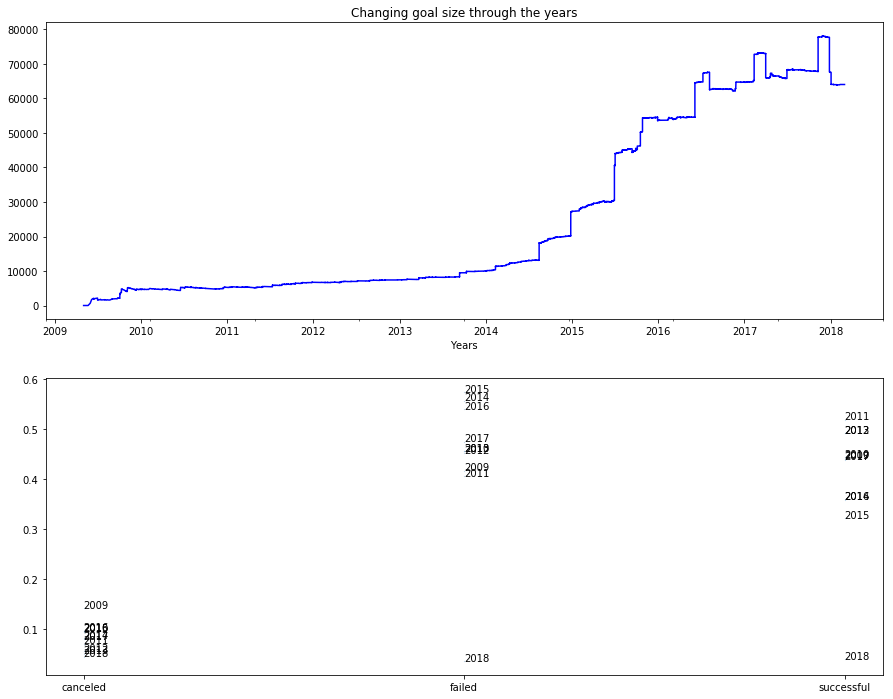

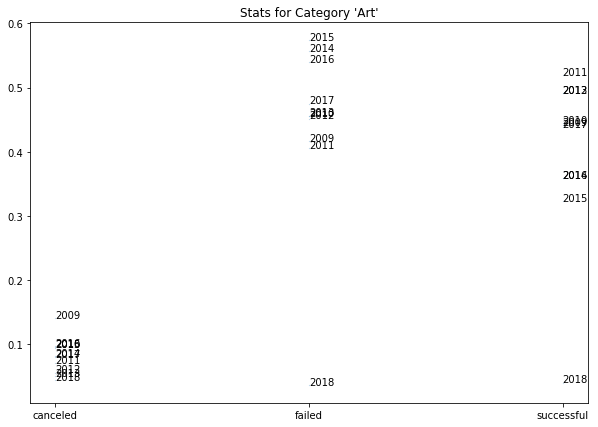

In [22]:
success_cat = 'Art'
plot_change_in_goalsize(moving_avgs, deadlines, success_cat)
plot_stats_per_year(df, success_cat)

### since 2014, the projects aren't as successful anymore as they used to be - projects got much more expensive since then (up to 80,000USD)
-> Projects should have a goal size of roughly 20,000USD

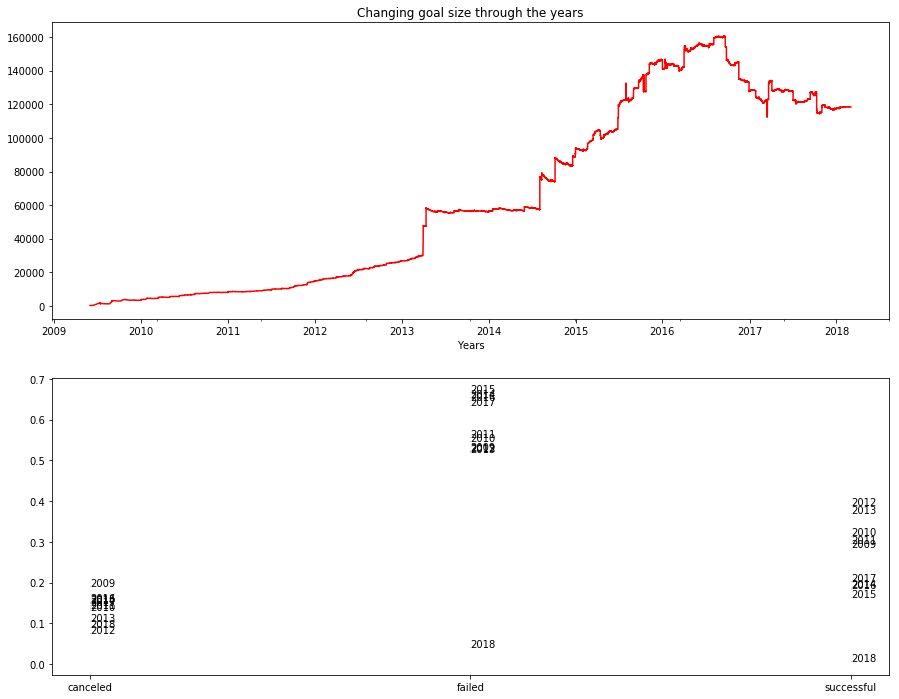

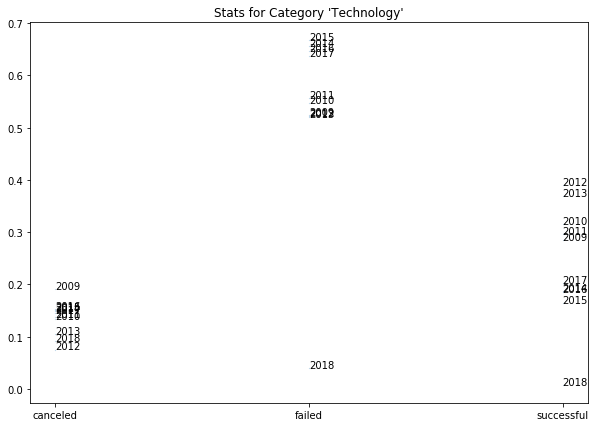

In [23]:
failed_cat = 'Technology'
plot_change_in_goalsize(moving_avgs, deadlines, failed_cat)
plot_stats_per_year(df, failed_cat)

-> am Graphen von Technology lässt sich sehr gut erkennen, dass ab dem Anstieg der durchschnittlichen Kosten-ziele ab 2014 weniger Projekte erfolgreich durchgeführt wurden! <br>
-> auch bei Art sieht man seit 2015 ein Sinken der Erfolgsrate, aber nicht in dem gleichen Maße

### PROJEKTLAUFZEITEN

In [24]:
tmp = df.groupby(['year_deadline', 'state'])['project_runtime'].mean()

In [25]:
states = []
years = defaultdict(list)
avg_days = defaultdict(list)
for idx, value in enumerate(tmp):
    year, state = tmp.index[idx]
    states.append(state)
    years[state].append(year)
    avg_days[state].append(value)
    #print(idx, tmp.index[idx], value)

In [26]:
colors = {
    'canceled': 'black',
    'failed': 'red',
    'live': 'cyan',
    'successful': 'green',
    'suspended': 'maroon',
    'undefined': 'magenta'
}

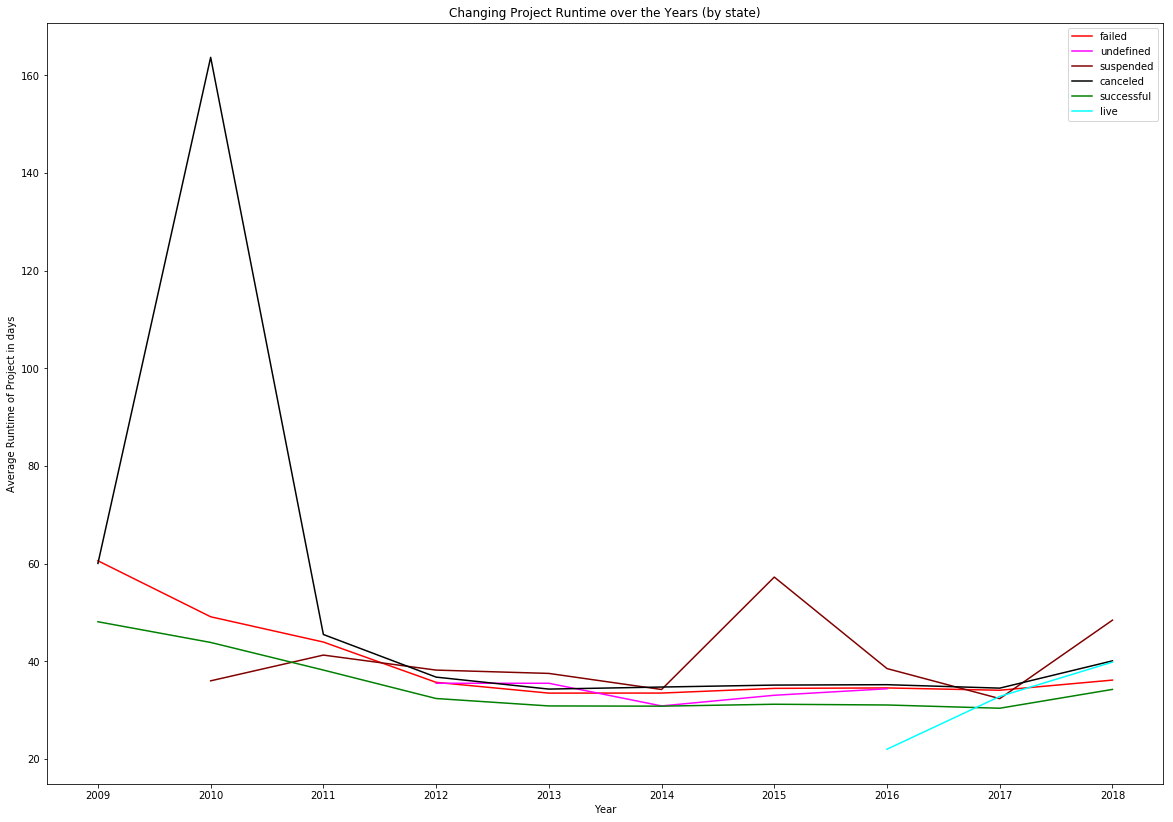

In [27]:
fig, ax = plt.subplots()
fig.set_size_inches(20, 14)
for state in set(states):
    ax.plot(years[state], avg_days[state], c=colors[state], label=state)
plt.legend()
plt.title("Changing Project Runtime over the Years (by state)")
plt.ylabel("Average Runtime of Project in days")
plt.xlabel("Year")
plt.xticks(list(set(years['successful'])))
plt.show()

# Result:
besonders erfolgreiche Projekte:
- gehören zu bestimmer Kategorie
- früher waren Projekte erfolgreicher
    - sie waren früher preiswerter
    - hatten eine längere Laufzeit